In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import flow
reload(flow)

import Detectors.Deep_Learning.AutoEncoders.utils
reload(Detectors.Deep_Learning.AutoEncoders.utils)
from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model

import torch
print(torch.__version__)

# Anti-Flow specific functions for  detection:

from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

import utils
reload(utils)

from utils import Bando_OVM_FTL

import os


from Adversaries.controllers import car_following_adversarial

reload(car_following_adversarial)

from Adversaries.controllers.car_following_adversarial import FollowerStopper_Overreact
from Adversaries.controllers.car_following_adversarial import ACC_Benign
from Adversaries.controllers.car_following_adversarial import ACC_Switched_Controller_Attacked

from flow.controllers.lane_change_controllers import AILaneChangeController

from utils import run_ring_sim_variable_cfm

print('Libraries loaded.')

1.7.1
Libraries loaded.


In [2]:
driver_controller_list_benign = []

#cfm parameters:
a_mean=0.666
b_mean=21.6
s0_mean=2.21
s1_mean=2.82
Vm_mean=8.94

#lane-change parameters:

left_delta_mean = 0.5
right_delta_mean = 0.3
left_beta_mean=1.5
right_beta_mean=1.5
switching_threshold_mean = 5.0

num_human_drivers = 35

for i in range(num_human_drivers):
    a = a_mean + np.random.normal(0,0.1)
    b = b_mean + np.random.normal(0,0.5)
    s0 = s0_mean + np.random.normal(0,0.2)
    s1 = s1_mean + np.random.normal(0,0.2)
    Vm = Vm_mean + np.random.normal(0,0.5)
    
    left_delta = left_delta_mean + np.random.normal(0,0.1)
    right_delta = right_delta_mean + np.random.normal(0,0.1)
    left_beta = left_beta_mean + np.random.normal(0,0.2)
    right_beta = right_beta_mean + np.random.normal(0,0.2)
    switching_threshold = switching_threshold_mean + np.random.normal(0,0.3)

    label = 'bando_ftl_ovm_a'+str(np.round(a,2))+'_b'+str(np.round(b,2))+'_s0'+str(np.round(s0,2))+'_s1'+str(np.round(s1,2))+'_Vm'+str(np.round(Vm,2))
    cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
    
    driver_controller_list_benign.append([label,cfm_controller,1])

k_1_mean = 1.5
k_2_mean = 0.2
h_mean = 1.8
V_m_mean = 15.0
d_min_mean = 10.0

for i in range(5):
    k_1 = k_1_mean + np.random.normal(0,0.2)
    k_2 = k_2_mean + np.random.normal(0,0.2)
    h = h_mean + np.random.normal(0,0.2)
    V_m = V_m_mean + np.random.normal(0,1.0)
    d_min = d_min_mean
    
    label = 'ACC_k_1'+str(np.round(k_1,2))+'_k_2'+str(np.round(k_2,2))+'_h'+str(np.round(h,2))+'_V_m'+str(np.round(V_m,2))+'d_m'+str(np.round(d_min,2))
    cfm_controller = (ACC_Benign,{'k_1':k_1,'k_2':k_2,'h':h,'V_m':V_m,'d_min':d_min})
    driver_controller_list_benign.append([label,cfm_controller,1])    
    
print('Benign drivers defined.')

Benign drivers defined.


In [4]:
sim_res_list_no_attack = run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list_benign,
                                                     ring_length=600,
                                                     sim_time=200)

print(sim_res_list_no_attack)

Number of classes of driver: 40
Running ring simulation, ring length: 600


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1055.6845676865853
data/ring_variable_cfm_20220510-1144321652201072.116596-0_emission.csv data
Average, std velocities: 5.9580241910140685, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1055.6845676865853, 0.0
Total time: 26.164870738983154
steps/second: 102.71487558781507
[{'velocities': [5.9580241910140685], 'outflows': [0.0], 'avg_trip_energy': [nan], 'avg_trip_time': [nan], 'total_completed_trips': [0], 'returns': [1055.6845676865853]}, 'data/ring_variable_cfm_20220510-1144321652201072.116596-0_emission.csv']


In [5]:
print(sim_res_list_no_attack)

[{'velocities': [5.9580241910140685], 'outflows': [0.0], 'avg_trip_energy': [nan], 'avg_trip_time': [nan], 'total_completed_trips': [0], 'returns': [1055.6845676865853]}, 'data/ring_variable_cfm_20220510-1144321652201072.116596-0_emission.csv']


In [37]:
from Adversaries.controllers import car_following_adversarial

reload(car_following_adversarial)

from Adversaries.controllers.car_following_adversarial import FollowerStopper_Overreact
from Adversaries.controllers.car_following_adversarial import ACC_Benign
from Adversaries.controllers.car_following_adversarial import ACC_Switched_Controller_Attacked

from flow.controllers.lane_change_controllers import AILaneChangeController

driver_controller_list_with_attack = []

#cfm parameters:
a_mean=0.666
b_mean=21.6
s0_mean=2.21
s1_mean=2.82
Vm_mean=8.94

#lane-change parameters:

left_delta_mean = 0.5
right_delta_mean = 0.3
left_beta_mean=1.5
right_beta_mean=1.5
switching_threshold_mean = 5.0

num_human_drivers = 35

for i in range(num_human_drivers):
    a = a_mean + np.random.normal(0,0.1)
    b = b_mean + np.random.normal(0,0.5)
    s0 = s0_mean + np.random.normal(0,0.2)
    s1 = s1_mean + np.random.normal(0,0.2)
    Vm = Vm_mean + np.random.normal(0,0.5)
    
    left_delta = left_delta_mean + np.random.normal(0,0.1)
    right_delta = right_delta_mean + np.random.normal(0,0.1)
    left_beta = left_beta_mean + np.random.normal(0,0.2)
    right_beta = right_beta_mean + np.random.normal(0,0.2)
    switching_threshold = switching_threshold_mean + np.random.normal(0,0.3)

    label = 'bando_ftl_ovm_a'+str(np.round(a,2))+'_b'+str(np.round(b,2))+'_s0'+str(np.round(s0,2))+'_s1'+str(np.round(s1,2))+'_Vm'+str(np.round(Vm,2))
    cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
    
    driver_controller_list_with_attack.append([label,cfm_controller,1])

k_1_mean = 1.5
k_2_mean = 0.2
h_mean = 1.8
V_m_mean = 15.0
d_min_mean = 10.0

for i in range(3):
    k_1 = k_1_mean + np.random.normal(0,0.2)
    k_2 = k_2_mean + np.random.normal(0,0.2)
    h = h_mean + np.random.normal(0,0.2)
    V_m = V_m_mean + np.random.normal(0,1.0)
    d_min = d_min_mean
    
    label = 'ACC_k_1'+str(np.round(k_1,2))+'_k_2'+str(np.round(k_2,2))+'_h'+str(np.round(h,2))+'_V_m'+str(np.round(V_m,2))+'d_m'+str(np.round(d_min,2))
    cfm_controller = (ACC_Benign,{'k_1':k_1,'k_2':k_2,'h':h,'V_m':V_m,'d_min':d_min})
    driver_controller_list_with_attack.append([label,cfm_controller,1])    
    
    

# v_des = 10.0
# braking_period = 5.0
# braking_rate = -3.0

k_1 = 1.5
k_2 = 0.2
h_mean = 1.8
V_m = 15.0
d_min = 10.0

want_multiple_attacks=True
Total_Attack_Duration = 3.0
attack_decel_rate = -.8
warmup_steps = 500
SS_Threshold_min = 60
display_attack_info = True

adversary = (ACC_Switched_Controller_Attacked, {'k_1':k_1,'k_2':k_2,'h':h,'V_m':V_m,'d_min':d_min,
                                                'want_multiple_attacks':want_multiple_attacks,
                                                'Total_Attack_Duration':Total_Attack_Duration,
                                                'attack_decel_rate':attack_decel_rate,
                                                'warmup_steps':warmup_steps,
                                                'SS_Threshold_min':SS_Threshold_min,
                                                'display_attack_info':display_attack_info})

ACC_label = '_k1_'+str(np.round(k_1,2))+'_k2_'+str(np.round(k_2,2))+'_h_'+str(np.round(h,2))+'_Vm_'+str(np.round(V_m,2))+'_dm_'+str(np.round(d_min,2))

label_adv = 'RDA_adv_TDA_'+str(np.round(Total_Attack_Duration,2))+'_ADR_'+str(np.round(attack_decel_rate,2))

label_adv = label_adv + ACC_label

driver_controller_list_with_attack.append([label_adv,adversary,1])



k_1 = 1.5
k_2 = 0.2
h_mean = 1.8
V_m = 15.0
d_min = 10.0

Total_Attack_Duration = 5.0
attack_decel_rate = -.5


adversary = (ACC_Switched_Controller_Attacked, {'k_1':k_1,'k_2':k_2,'h':h,'V_m':V_m,'d_min':d_min,
                                                'want_multiple_attacks':want_multiple_attacks,
                                                'Total_Attack_Duration':Total_Attack_Duration,
                                                'attack_decel_rate':attack_decel_rate,
                                                'warmup_steps':warmup_steps,
                                                'SS_Threshold_min':SS_Threshold_min,
                                                'display_attack_info':display_attack_info})

ACC_label = '_k1_'+str(np.round(k_1,2))+'_k2_'+str(np.round(k_2,2))+'_h_'+str(np.round(h,2))+'_Vm_'+str(np.round(V_m,2))+'_dm_'+str(np.round(d_min,2))

label_adv = 'RDA_adv_TDA_'+str(np.round(Total_Attack_Duration,2))+'_ADR_'+str(np.round(attack_decel_rate,2))

label_adv = label_adv + ACC_label

driver_controller_list_with_attack.append([label_adv,adversary,1])
    
print('Drivers with compromise defined.')

Drivers with compromise defined.


In [10]:
sim_res_list_with_attack = run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list_with_attack,
                                                     ring_length=600,
                                                     sim_time=300)

print('Finished attack with RDAs.')

Number of classes of driver: 40
Running ring simulation, ring length: 600
Spawning compromised ACC, attack frequency: 61.74062802729075
Will engage in multiple attacks.
Spawning compromised ACC, attack frequency: 79.62499190099948
Will engage in multiple attacks.
Beginning attack: RDA_adv_TDA_5.0_ADR_-0.5_k1_1.5_k2_0.2_h_1.72_Vm_15.0_dm_10.0_0 Time: 61.800000000000004
Attack finished:RDA_adv_TDA_5.0_ADR_-0.5_k1_1.5_k2_0.2_h_1.72_Vm_15.0_dm_10.0_0, -0.5, 5.0, 66.9
Beginning attack: RDA_adv_TDA_3.0_ADR_-0.8_k1_1.5_k2_0.2_h_1.72_Vm_15.0_dm_10.0_0 Time: 79.80000000000001
Attack finished:RDA_adv_TDA_3.0_ADR_-0.8_k1_1.5_k2_0.2_h_1.72_Vm_15.0_dm_10.0_0, -0.8, 3.0, 82.80000000000001
Beginning attack: RDA_adv_TDA_5.0_ADR_-0.5_k1_1.5_k2_0.2_h_1.72_Vm_15.0_dm_10.0_0 Time: 128.70000000000002
Attack finished:RDA_adv_TDA_5.0_ADR_-0.5_k1_1.5_k2_0.2_h_1.72_Vm_15.0_dm_10.0_0, -0.5, 5.0, 133.8
Beginning attack: RDA_adv_TDA_3.0_ADR_-0.8_k1_1.5_k2_0.2_h_1.72_Vm_15.0_dm_10.0_0 Time: 162.5
Attack finished:R

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1510.12095666953
data/ring_variable_cfm_20220510-1250131652205013.519551-0_emission.csv data
Average, std velocities: 5.826107647584207, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1510.12095666953, 0.0
Total time: 61.790385007858276
steps/second: 98.12204524236398
Finished attack with RDAs.


In [6]:
import numpy as np

import time

from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model,get_cnn_lstm_ae_model,make_train_X,sliding_window_mult_feat

from Detectors.Deep_Learning.AutoEncoders.utils import get_loss_filter_indiv as loss_smooth

import flow.visualize.visualize_ring as visualize_ring
reload(visualize_ring)

from flow.visualize.visualize_ring import get_measured_leader,get_rel_dist_to_measured_leader,get_vel_of_measured_leader

from copy import deepcopy

import sys

print('Imported detection tools.')

Imported detection tools.


In [7]:
def train_ring_relative_detector(GPS_penetration_rate,ring_length,emission_path,n_epoch=200):

    warmup_period = 50 #Wait until there's a well developed wave

    timeseries_dict = visualize_ring.get_sim_timeseries(csv_path=emission_path,warmup_period=warmup_period)

    veh_ids = list(timeseries_dict.keys())

    num_measured_vehicle_ids = int(np.floor(len(veh_ids)*GPS_penetration_rate))
    measured_veh_ids = deepcopy(veh_ids)

    for i in range(len(measured_veh_ids)-num_measured_vehicle_ids):
        rand_int = np.random.randint(0,len(measured_veh_ids))
        del measured_veh_ids[rand_int]

    ring_sim_dict = visualize_ring.get_sim_data_dict_ring(csv_path=emission_path,warmup_period=warmup_period)

    timeseries_list = []

    for veh_id in measured_veh_ids:
        #[time,speed,headway,accel,leader_speed,fuel_consumption]
        speed = timeseries_dict[veh_id][:,1]
        accel = np.gradient(speed,.1)
        head_way = timeseries_dict[veh_id][:,2]
        rel_vel = timeseries_dict[veh_id][:,3]
        
        timeseries_list.append([speed,accel,head_way,rel_vel])

    train_X = make_train_X(timeseries_list)

    model = get_cnn_lstm_ae_model(n_features=4)

    model_file_name = 'ringlength'+str(ring_length)+'_1lane_'+'_'+str(GPS_penetration_rate)+'percentGPS'

    print('Model: '+model_file_name)

    print('Beginning training...')
    begin_time = time.time()
    model = train_model(model,train_X,model_file_name,n_epoch=n_epoch)
    finish_time = time.time()
    print('Finished training, total time: '+str(finish_time-begin_time))

    return model


ring_length = 600
GPS_penetration_rate = 1.0

emission_path = os.path.join(os.getcwd(),sim_res_list_no_attack[1])

rel_info_AE_detector = train_ring_relative_detector(GPS_penetration_rate,
                                                    ring_length,
                                                    emission_path,
                                                    n_epoch=75)

Data loaded.
Data loaded.
Model: ringlength600_1lane__1.0percentGPS
Beginning training...
Creating new model.
Epoch 0, total loss 223426.025208, total predictions 4000, avg loss 55.856506 2022-05-10 11:46:01.889431
Saving model. Best loss: 55.85650630187988
Saving model. Best loss: 55.805251144409176
Saving model. Best loss: 52.857063987731934
Saving model. Best loss: 52.005128547668455
Saving model. Best loss: 48.0450094833374
Epoch 5, total loss 181814.882355, total predictions 4000, avg loss 45.453721 2022-05-10 11:47:22.393862
Saving model. Best loss: 45.453720588684085
Saving model. Best loss: 40.128575698852536
Saving model. Best loss: 35.230419921875
Saving model. Best loss: 31.993901222229002
Saving model. Best loss: 30.06264469909668
Epoch 10, total loss 110820.421936, total predictions 4000, avg loss 27.705105 2022-05-10 11:48:45.123045
Saving model. Best loss: 27.70510548400879
Saving model. Best loss: 26.67349053955078
Saving model. Best loss: 22.157154155731202
Epoch 15, t

In [19]:
reload(Detectors.Deep_Learning.AutoEncoders.utils)
reload(utils)
from utils import assess_relative_model_on_attack
import time


#This is custom for total observation:

def get_losses(timeseries_dict,model,warmup_steps=500,want_timeseries_plot=True):
    veh_ids = list(timeseries_dict.keys())
   
    num_veh_processed = 0

    testing_losses_dict = dict.fromkeys(veh_ids)

    for veh_id in veh_ids:
        timeseries_list = []
        
        speed = timeseries_dict[veh_id][warmup_steps:,1]
        accel = np.gradient(speed,.1)
        head_way = timeseries_dict[veh_id][warmup_steps:,2]
        rel_vel = timeseries_dict[veh_id][warmup_steps:,3]
        
        timeseries_list.append([speed,accel,head_way,rel_vel])

        timeseries_list = [speed,accel,head_way,rel_vel]

        _,loss = sliding_window_mult_feat(model,timeseries_list)

        testing_losses_dict[veh_id]=loss

        num_veh_processed+=1

        sys.stdout.write('\r'+'Vehicles processed: '+str(num_veh_processed)+'\r')

    print('\n')
    
    smoothed_losses = dict.fromkeys(veh_ids)
    time = timeseries_dict[veh_ids[0]][warmup_steps:,0]
    
    #Get smoothed loss values:
    for veh_id in veh_ids:
        loss = testing_losses_dict[veh_id]
        smoothed_loss = loss_smooth(time,loss)
            
        smoothed_losses[veh_id] =  loss_smooth(time,loss)

    
    if(want_timeseries_plot):
        plt.figure()
        
        for veh_id in veh_ids:
            smoothed_loss = smoothed_losses[veh_id]
            if('FStop' in veh_id):
                plt.plot(smoothed_loss,'r')
            else:
                plt.plot(smoothed_loss,'b')
        
    return smoothed_losses



model = rel_info_AE_detector

In [12]:
no_attack_csv_path = os.path.join(os.getcwd(),sim_res_list_no_attack[1])

attacked_csv_path = os.path.join(os.getcwd(),sim_res_list_with_attack[1])

sim_timeseries_dict_no_attack = visualize_ring.get_sim_timeseries(no_attack_csv_path)

sim_timeseries_dict_with_attack = visualize_ring.get_sim_timeseries(attacked_csv_path)

print('Loaded timeseries dicts.')

Data loaded.
Data loaded.
Loaded timeseries dicts.


Vehicles processed: 40

Vehicles processed: 40

Losses found.


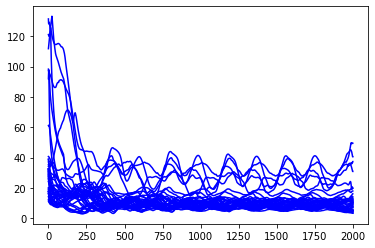

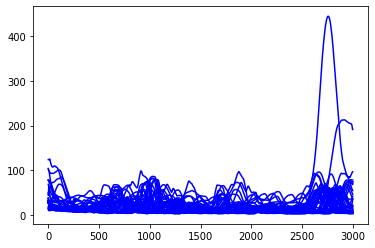

In [13]:
losses_no_attack = get_losses(sim_timeseries_dict_no_attack,model)

losses_with_attack = get_losses(sim_timeseries_dict_with_attack,model)

print('Losses found.')

Text(0, 0.5, 'Max loss')

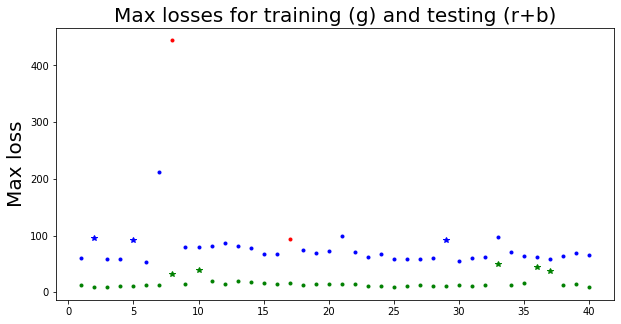

In [15]:
veh_ids_no_attacks = list(losses_no_attack.keys())

veh_ids_with_attacks = list(losses_with_attack.keys())


plt.figure(figsize=[10,5])


tmp = 1

for veh_id in veh_ids_no_attacks:
    max_loss = np.max(losses_no_attack[veh_id][500:])
    
    if('ACC' in veh_id):
        plt.plot(tmp,max_loss,'g*')
        tmp += 1
        
    else:
        plt.plot(tmp,max_loss,'g.')
        tmp += 1        
    
tmp = 1
for veh_id in veh_ids_with_attacks:
    max_loss = np.max(losses_with_attack[veh_id][500:])
    
    if('RDA_adv' in veh_id):
        plt.plot(tmp,max_loss,'r.')
        tmp += 1
    else:
        if('ACC' in veh_id):
            plt.plot(tmp,max_loss,'b*')
            tmp += 1
        else:
            plt.plot(tmp,max_loss,'b.')
            tmp += 1

plt.title('Max losses for training (g) and testing (r+b)',fontsize=20)
plt.ylabel('Max loss',fontsize=20)

# Test the effect of stochasticity on assignment of Rec-Errors:

In [48]:
reload(utils)

import time

from utils import run_ring_sim_variable_cfm

# Total_Attack_Duration = 3.0

# attack_decel_rate = -0.8


def make_mal_driver_list(Total_Attack_Duration=3.0,attack_decel_rate = -.8):

    driver_controller_list_with_attack = []

    #cfm parameters:
    a_mean=0.666
    b_mean=21.6
    s0_mean=2.21
    s1_mean=2.82
    Vm_mean=8.94

    #lane-change parameters:

    left_delta_mean = 0.5
    right_delta_mean = 0.3
    left_beta_mean=1.5
    right_beta_mean=1.5
    switching_threshold_mean = 5.0

    num_human_drivers = 35

    for i in range(num_human_drivers):
        a = a_mean + np.random.normal(0,0.1)
        b = b_mean + np.random.normal(0,0.5)
        s0 = s0_mean + np.random.normal(0,0.2)
        s1 = s1_mean + np.random.normal(0,0.2)
        Vm = Vm_mean + np.random.normal(0,0.5)

        left_delta = left_delta_mean + np.random.normal(0,0.1)
        right_delta = right_delta_mean + np.random.normal(0,0.1)
        left_beta = left_beta_mean + np.random.normal(0,0.2)
        right_beta = right_beta_mean + np.random.normal(0,0.2)
        switching_threshold = switching_threshold_mean + np.random.normal(0,0.3)

        label = 'bando_ftl_ovm_a'+str(np.round(a,2))+'_b'+str(np.round(b,2))+'_s0'+str(np.round(s0,2))+'_s1'+str(np.round(s1,2))+'_Vm'+str(np.round(Vm,2))
        cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})

        driver_controller_list_with_attack.append([label,cfm_controller,1])

    k_1_mean = 1.5
    k_2_mean = 0.2
    h_mean = 1.8
    V_m_mean = 15.0
    d_min_mean = 10.0

    for i in range(3):
        k_1 = k_1_mean + np.random.normal(0,0.2)
        k_2 = k_2_mean + np.random.normal(0,0.2)
        h = h_mean + np.random.normal(0,0.2)
        V_m = V_m_mean + np.random.normal(0,1.0)
        d_min = d_min_mean

        label = 'ACC_k_1'+str(np.round(k_1,2))+'_k_2'+str(np.round(k_2,2))+'_h'+str(np.round(h,2))+'_V_m'+str(np.round(V_m,2))+'d_m'+str(np.round(d_min,2))
        cfm_controller = (ACC_Benign,{'k_1':k_1,'k_2':k_2,'h':h,'V_m':V_m,'d_min':d_min})
        driver_controller_list_with_attack.append([label,cfm_controller,1])    



    # v_des = 10.0
    # braking_period = 5.0
    # braking_rate = -3.0

    k_1 = k_1_mean + np.random.normal(0,0.2)
    k_2 = k_2_mean + np.random.normal(0,0.2)
    h = h_mean + np.random.normal(0,0.2)
    V_m = V_m_mean + np.random.normal(0,1.0)
    d_min = d_min_mean

    want_multiple_attacks=True
#     Total_Attack_Duration = 3.0
#     attack_decel_rate = -.8
    warmup_steps = 500
    SS_Threshold_min = 60
    display_attack_info = True

    adversary = (ACC_Switched_Controller_Attacked, {'k_1':k_1,'k_2':k_2,'h':h,'V_m':V_m,'d_min':d_min,
                                                    'want_multiple_attacks':want_multiple_attacks,
                                                    'Total_Attack_Duration':Total_Attack_Duration,
                                                    'attack_decel_rate':attack_decel_rate,
                                                    'warmup_steps':warmup_steps,
                                                    'SS_Threshold_min':SS_Threshold_min,
                                                    'display_attack_info':display_attack_info})

    print(adversary)
    
    ACC_label = '_k1_'+str(np.round(k_1,2))+'_k2_'+str(np.round(k_2,2))+'_h_'+str(np.round(h,2))+'_Vm_'+str(np.round(V_m,2))+'_dm_'+str(np.round(d_min,2))

    label_adv = 'RDA_adv_TDA_'+str(np.round(Total_Attack_Duration,2))+'_ADR_'+str(np.round(attack_decel_rate,2))

    label_adv = label_adv + ACC_label

    driver_controller_list_with_attack.append([label_adv,adversary,1])


    k_1 = k_1_mean + np.random.normal(0,0.2)
    k_2 = k_2_mean + np.random.normal(0,0.2)
    h = h_mean + np.random.normal(0,0.2)
    V_m = V_m_mean + np.random.normal(0,1.0)
    d_min = d_min_mean

#     Total_Attack_Duration = 5.0
#     attack_decel_rate = -.5


    adversary = (ACC_Switched_Controller_Attacked, {'k_1':k_1,'k_2':k_2,'h':h,'V_m':V_m,'d_min':d_min,
                                                    'want_multiple_attacks':want_multiple_attacks,
                                                    'Total_Attack_Duration':Total_Attack_Duration,
                                                    'attack_decel_rate':attack_decel_rate,
                                                    'warmup_steps':warmup_steps,
                                                    'SS_Threshold_min':SS_Threshold_min,
                                                    'display_attack_info':display_attack_info})
    
    print(adversary)

    ACC_label = '_k1_'+str(np.round(k_1,2))+'_k2_'+str(np.round(k_2,2))+'_h_'+str(np.round(h,2))+'_Vm_'+str(np.round(V_m,2))+'_dm_'+str(np.round(d_min,2))

    label_adv = 'RDA_adv_TDA_'+str(np.round(Total_Attack_Duration,2))+'_ADR_'+str(np.round(attack_decel_rate,2))

    label_adv = label_adv + ACC_label

    driver_controller_list_with_attack.append([label_adv,adversary,1])


    return driver_controller_list_with_attack


def run_sim_with_attack(Total_Attack_Duration,attack_decel_rate):
    
    driver_controller_list_with_attack = make_mal_driver_list(Total_Attack_Duration,attack_decel_rate)
    
    sim_res_list_with_attack = run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list_with_attack,
                                                     ring_length=600,
                                                     sim_time=200)
    
    emission_path = os.path.join(os.getcwd(),sim_res_list_with_attack[1])
    
    return emission_path

def get_losses_from_attack(Total_Attack_Duration,attack_decel_rate,model,delete_file=True):
    
    emission_path = run_sim_with_attack(Total_Attack_Duration,attack_decel_rate)
    
    sim_timeseries_dict_with_attack = visualize_ring.get_sim_timeseries(emission_path)
    
    losses_dict = get_losses(sim_timeseries_dict_with_attack,model,warmup_steps=500,want_timeseries_plot=False)
    
    if(delete_file):
        os.remove(emission_path)

    return losses_dict


# driver_controller_list_with_attack = make_mal_driver_list(Total_Attack_Duration,attack_decel_rate)

# sim_res_list_with_attack = run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list_with_attack,
#                                                  ring_length=600,
#                                                  sim_time=200)

print('Sampling functions defined.')
    

Sampling functions defined.


In [49]:
Total_Attack_Duration = 3.0
attack_decel_rate = -0.8 

num_runs = 15

print('Beginning sampling run:')

losses_dict = get_losses_from_attack(Total_Attack_Duration,attack_decel_rate,model)

sim_losses_results = []

model = rel_info_AE_detector

for i in range(num_runs):
    
    begin_sim_time = time.time()
    
    losses_dict = get_losses_from_attack(Total_Attack_Duration,attack_decel_rate,model)
    
    sim_losses_results.append(losses_dict)
    
    finish_sim_time = time.time()
    
    print('Simulation number: '+str(i))
    print('Simulation time: '+str(finish_sim_time-begin_sim_time))

Beginning sampling run:
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.2558640264426977, 'k_2': 0.5095277608404833, 'h': 2.064242175283816, 'V_m': 15.566849516238637, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.8907403299407106, 'k_2': 0.04614764301801319, 'h': 2.0415242203091473, 'V_m': 15.981065788015059, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
Number of classes of driver: 40
Running ring simulation, ring length: 600
Spawning compromised ACC, attack frequency: 69.5242891978959
Will engage in multiple attacks.
Spawning compromised ACC, attack frequency: 75.0

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1037.263023300096
data/ring_variable_cfm_20220511-1032341652283154.7907908-0_emission.csv data
Average, std velocities: 5.956957165214015, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1037.263023300096, 0.0
Total time: 17.40065598487854
steps/second: 131.14487186784092
Data loaded.
Vehicles processed: 40

(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.7939343471774991, 'k_2': 0.3638233312194358, 'h': 2.0188017013528143, 'V_m': 14.234899282654323, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.4677305493591677, 'k_2': 0.2975826340325104, 'h': 1.66004

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1045.6789024367583
data/ring_variable_cfm_20220511-1034041652283244.389153-0_emission.csv data
Average, std velocities: 5.904871666759252, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1045.6789024367583, 0.0
Total time: 19.8387131690979
steps/second: 119.69157121603467
Data loaded.
Vehicles processed: 40

Simulation number: 0
Simulation time: 94.52978777885437
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.2767139669750565, 'k_2': 0.38099271487596387, 'h': 1.7734509696981184, 'V_m': 16.45370914743156, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.7

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1058.9698352328824
data/ring_variable_cfm_20220511-1035381652283338.919256-0_emission.csv data
Average, std velocities: 5.968373566519137, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1058.9698352328824, 0.0
Total time: 17.937418937683105
steps/second: 127.23207907605892
Data loaded.
Vehicles processed: 40

Simulation number: 1
Simulation time: 85.37526082992554
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.503151097666102, 'k_2': 0.36547377340583237, 'h': 1.922562188597876, 'V_m': 14.418456645594008, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data/ring_variable_cfm_20220511-1037041652283424.294196-0_emission.csv data
Average, std velocities: 6.052628921428394, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1102.4678579668314, 0.0
Total time: 17.487043857574463
steps/second: 129.9194173107296
Data loaded.
Vehicles processed: 40

Simulation number: 2
Simulation time: 84.20416498184204
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.7652891898536716, 'k_2': 0.05097216601745155, 'h': 1.7937320255411626, 'V_m': 14.558145394889197, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.7520525307893995, 'k_2': 0.42184968

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1081.0761335328605
data/ring_variable_cfm_20220511-1038281652283508.4993558-0_emission.csv data
Average, std velocities: 6.030528928623565, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1081.0761335328605, 0.0
Total time: 17.406035900115967
steps/second: 130.6121162304084
Data loaded.
Vehicles processed: 40

Simulation number: 3
Simulation time: 84.23610591888428
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.487955575912395, 'k_2': 0.054574027225934824, 'h': 1.555957758803173, 'V_m': 15.696595677149103, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1096.9006678408637
data/ring_variable_cfm_20220511-1039521652283592.734912-0_emission.csv data
Average, std velocities: 6.135999201252335, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1096.9006678408637, 0.0
Total time: 17.36589217185974
steps/second: 130.87069493127555
Data loaded.
Vehicles processed: 40

Simulation number: 4
Simulation time: 84.04969215393066
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.4866564676952696, 'k_2': 0.012763831867959458, 'h': 1.2440697301905113, 'V_m': 14.113810416783547, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1115.2534881745205
data/ring_variable_cfm_20220511-1041161652283676.7849011-0_emission.csv data
Average, std velocities: 6.327812503465387, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1115.2534881745205, 0.0
Total time: 17.304823875427246
steps/second: 131.15602758614563
Data loaded.
Vehicles processed: 40

Simulation number: 5
Simulation time: 83.93649911880493
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.8038972155811575, 'k_2': 0.17405894269266775, 'h': 1.774842752233726, 'V_m': 14.066050969534224, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1080.0716204068945
data/ring_variable_cfm_20220511-1042401652283760.7215412-0_emission.csv data
Average, std velocities: 6.038581410347346, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1080.0716204068945, 0.0
Total time: 17.328176975250244
steps/second: 131.04535629210696
Data loaded.
Vehicles processed: 40

Simulation number: 6
Simulation time: 83.65320181846619
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.4719892544487898, 'k_2': 0.030054336244854707, 'h': 1.9974261975793202, 'V_m': 14.934293337151376, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1'

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1063.7924019556274
data/ring_variable_cfm_20220511-1044041652283844.3748841-0_emission.csv data
Average, std velocities: 6.109199897612577, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1063.7924019556274, 0.0
Total time: 17.31030297279358
steps/second: 131.3622953563784
Data loaded.
Vehicles processed: 40

Simulation number: 7
Simulation time: 86.87697792053223
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.3287786483456876, 'k_2': 0.2555913643253075, 'h': 2.0017600636188067, 'V_m': 16.294542225987318, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data/ring_variable_cfm_20220511-1045311652283931.252324-0_emission.csv data
Average, std velocities: 5.980458367539132, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1035.5497636313844, 0.0
Total time: 17.540672063827515
steps/second: 129.99670205224677
Data loaded.
Vehicles processed: 40

Simulation number: 8
Simulation time: 85.37406277656555
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.4322790873880558, 'k_2': 0.0570594385071429, 'h': 1.6916160823048452, 'V_m': 14.895853715028483, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.5124886086359783, 'k_2': 0.23738542

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1040.2978803842668
data/ring_variable_cfm_20220511-1046561652284016.6263978-0_emission.csv data
Average, std velocities: 5.941219920560044, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1040.2978803842668, 0.0
Total time: 17.546100854873657
steps/second: 129.88379875344646
Data loaded.
Vehicles processed: 40

Simulation number: 9
Simulation time: 84.34188485145569
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.568232090284028, 'k_2': 0.31495476400211064, 'h': 1.53400195928961, 'V_m': 14.323656620827158, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1060.2565966338916
data/ring_variable_cfm_20220511-1048201652284100.96812-0_emission.csv data
Average, std velocities: 6.137064211006644, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1060.2565966338916, 0.0
Total time: 17.33886694908142
steps/second: 131.24273041286116
Data loaded.
Vehicles processed: 40

Simulation number: 10
Simulation time: 86.09837484359741
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.8714828284112646, 'k_2': 0.5041472050208906, 'h': 2.0984098057243865, 'V_m': 13.98057455507537, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.7

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1131.0049290806057
data/ring_variable_cfm_20220511-1049471652284187.0674298-0_emission.csv data
Average, std velocities: 6.26841883734153, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1131.0049290806057, 0.0
Total time: 17.293357133865356
steps/second: 131.32193090291773
Data loaded.
Vehicles processed: 40

Simulation number: 11
Simulation time: 83.7858190536499
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.6039651316173533, 'k_2': 0.222531954693651, 'h': 1.8768292929728019, 'V_m': 17.316602296105263, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 992.918433832161
data/ring_variable_cfm_20220511-1051101652284270.9483142-0_emission.csv data
Average, std velocities: 5.555125035582935, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 992.918433832161, 0.0
Total time: 17.25240993499756
steps/second: 131.96033668846826
Data loaded.
Vehicles processed: 40

Simulation number: 12
Simulation time: 83.73534202575684
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.5582049625637384, 'k_2': 0.10293752276089935, 'h': 1.7094824034302587, 'V_m': 14.452499917417354, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.7

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1000.2964181768564
data/ring_variable_cfm_20220511-1052341652284354.588557-0_emission.csv data
Average, std velocities: 6.022764378844784, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1000.2964181768564, 0.0
Total time: 17.372984170913696
steps/second: 131.1492667588841
Data loaded.
Vehicles processed: 40

Simulation number: 13
Simulation time: 84.08384418487549
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.6000085560736264, 'k_2': 0.0743739960507408, 'h': 1.748832903180162, 'V_m': 13.714722540292804, 'd_min': 10.0, 'want_multiple_attacks': True, 'Total_Attack_Duration': 3.0, 'attack_decel_rate': -0.8, 'warmup_steps': 500, 'SS_Threshold_min': 60, 'display_attack_info': True})
(<class 'Adversaries.controllers.car_following_adversarial.ACC_Switched_Controller_Attacked'>, {'k_1': 1.

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1008.2806200100891
data/ring_variable_cfm_20220511-1053581652284438.672467-0_emission.csv data
Average, std velocities: 5.784897251871827, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1008.2806200100891, 0.0
Total time: 17.410162925720215
steps/second: 131.65110478516692
Data loaded.
Vehicles processed: 40

Simulation number: 14
Simulation time: 84.09697604179382


In [ ]:
from copy import deepcopy



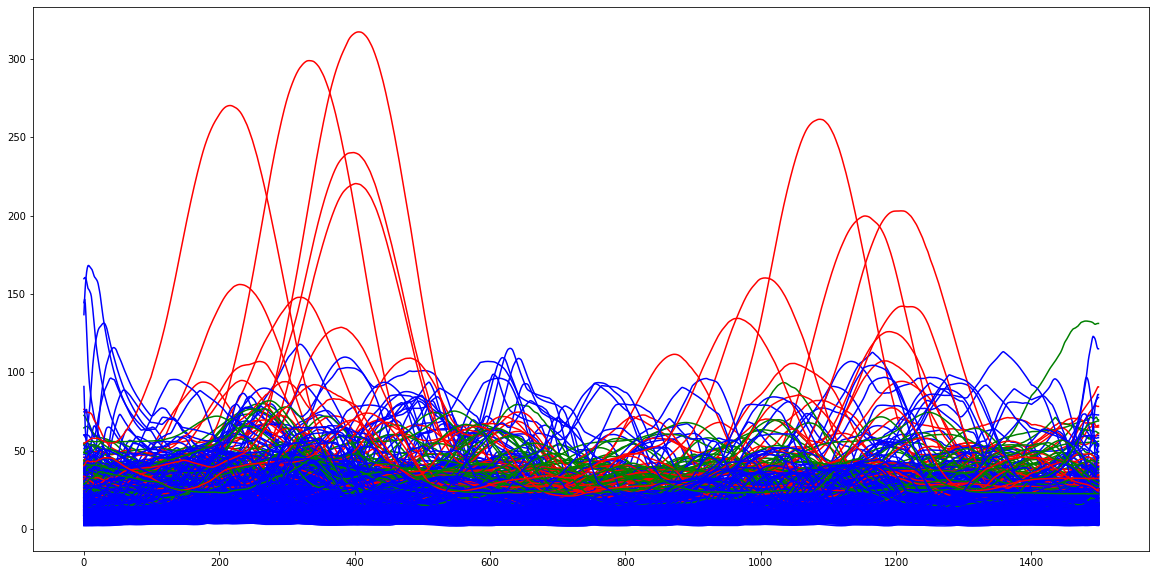

In [50]:
plt.figure(figsize=[20,10])

for i in range(num_runs):
    losses_dict = sim_losses_results[i]
    
    veh_ids = list(losses_dict.keys())
    
    for veh_id in veh_ids:
        losses = losses_dict[veh_id]
        if('RDA_adv' in veh_id):
            plt.plot(losses,'r')
        else:
            if('ACC' in veh_id):
                plt.plot(losses,'g')
            else:
                plt.plot(losses,'b')
                    
            
            

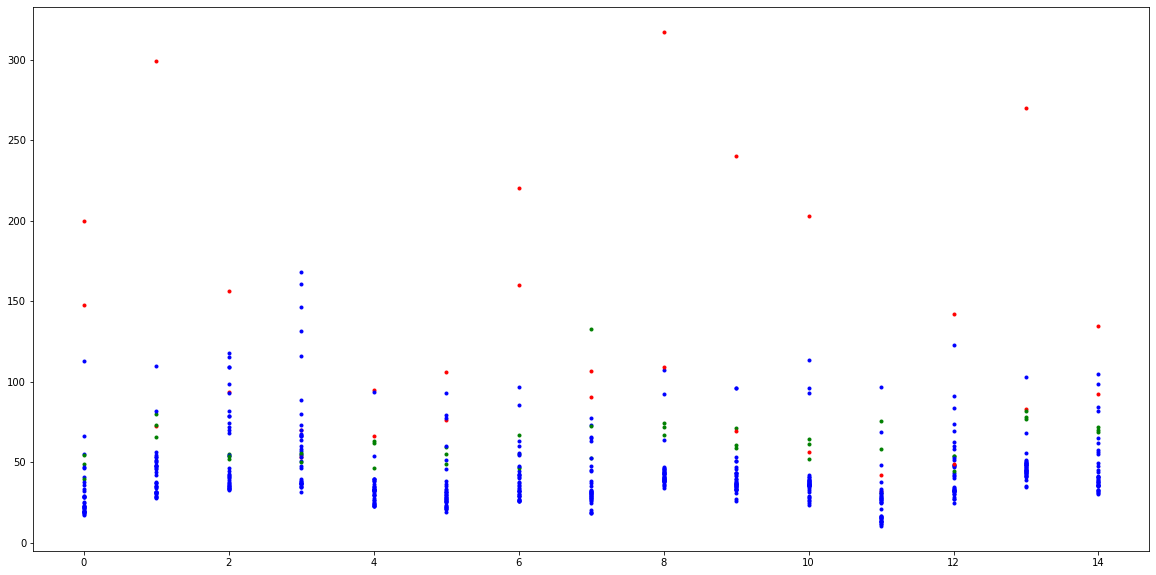

In [54]:
plt.figure(figsize=[20,10])

tmp = 0

for i in range(num_runs):
    losses_dict = sim_losses_results[i]
    
    veh_ids = list(losses_dict.keys())
    
    for veh_id in veh_ids:
        losses = losses_dict[veh_id]
        max_loss = np.max(losses)
        if('RDA_adv' in veh_id):
            plt.plot(tmp,max_loss,'r.')
        else:
            if('ACC' in veh_id):
                plt.plot(tmp,max_loss,'g.')
            else:
                plt.plot(tmp,max_loss,'b.')
        
    tmp += 1
                    